In [3]:
# default_exp pnl_sim

In [4]:
# export

import logging
import numpy as np
import pandas as pd

STEP_SIZE = 0.05
from mlfinlab.bet_sizing.ch10_snippets import get_signal


def long_short_strongest_signals(df, n):
    values = df.values
    # Impute nans to 0 so numpy doesn't sort them to the top
    values[np.isnan(values)] = 0

    sorty = values.argsort()

    shorts = pd.DataFrame(sorty[:, :n])
    longs = pd.DataFrame(sorty[:, -n:])

    shorts_s = shorts.apply(lambda x:df.columns[x])
    longs_s = longs.apply(lambda x:df.columns[x])

    la = longs_s.apply(lambda x: ','.join(x), axis=1).str.get_dummies(sep=',')
    sa = -shorts_s.apply(lambda x: ','.join(x), axis=1).str.get_dummies(sep=',')

    XX = la[la != 0].combine_first(sa[sa != 0])

    XX = XX.set_index(df.index)
    XX = XX.reindex(columns=df.columns)

    return XX.fillna(0)

def get_pnl_reports(events, symbols, binarize, binarize_params):
    """Groups our grand frames by symbol and extracts the average active signal that we'll use to trade later"""
    closes = []
    clf_signals = []
    alpha_signals = []
    logging.info(
        f"Generating signals for {len(symbols)} symbols on {len(events)} events with b_params={binarize_params}"
    )

    for key, group in events.groupby(events.index.microsecond):
        symbol = symbols[key]
        close = group["close_p"]
        close.name = symbol
        closes.append(close)
        if "side" in group:
            # Meta-labeling
            alpha_s = group["side"]
            alpha_s.name = symbol
            alpha_signals.append(alpha_s)
            signal = group["y_pred"] * group["side"]
        else:
            signal = group["y_pred"]

        pred, prob = group['y_pred'], group['y_pred_proba']

        clf_s = get_signal(prob.where(prob >= 0.5, 1 - prob), 2, pred)

        clf_s.name = symbol
        clf_signals.append(clf_s)

    closes = pd.concat(closes, axis=1).ffill()
    clf_signals = pd.concat(clf_signals, axis=1).ffill()

    clf_signals = long_short_strongest_signals(clf_signals, n=20)

    new_df = pd.DataFrame(index=clf_signals.index, columns=clf_signals.columns)
    for key, group in clf_signals.groupby(clf_signals.index.microsecond):
        symbol = symbols[key]
        new_df.loc[group.index, symbol] = group[symbol].rolling(binarize_params).mean()

    # Expire any signal after a runway of 2% of the total length (roughly 1 month over 5 years)
    # This helps clear our low-frequency signals (such as on Crncy futures)
    clf_signals = new_df.ffill(limit=int(new_df.shape[0] * 0.02)).fillna(0)
    clf_signals = discrete_signal(clf_signals, STEP_SIZE)

    if "side" in events:
        alpha_signals = pd.concat(alpha_signals, axis=1).ffill()
    else:
        alpha_signals = None

    return closes, clf_signals, alpha_signals


def discrete_signal(signal0, step_size):
    # discretize signal
    signal1 = (signal0 / step_size).round() * step_size
    return signal1.clip(-1, 1)

C:\Users\doda\Anaconda3\envs\fincl2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\doda\Anaconda3\envs\fincl2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
import matplotlib
import matplotlib.pyplot as mpl

%matplotlib inline
mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = 16, 6

import mlbt.settings_pers as settings

def make_default_config(**data):
    DATA_DIR = data.get("DATA_DIR", settings.DATA_DIR)

    return {
        "DATA_DIR": DATA_DIR,
        "F_PAYLOAD_DIR": data.get("F_PAYLOAD_DIR", settings.F_PAYLOAD_DIR),
        "symbols_map": pd.read_csv(DATA_DIR / "symbols.csv", index_col="iqsymbol"),
    }

import json
fns = [settings.DATA_DIR / 'payloads/payload_agriculture-currency-energy-equity_index-interest_rate-metals_dollar_fixed_horizon_50_none_[]_xgboost.json']

our_config = make_default_config()


from mlbt.tearsheets import load_payloads

plds = load_payloads(fns, our_config)

pld = plds[0]
config, pay_j, events, close, primary_signals, secondary_signals = pld

events.columns

for k, ev_g in events.groupby(events.index.microsecond):
    print(k, ev_g['y_pred'].value_counts())

C:\Users\doda\Anaconda3\envs\fincl2\lib\site-packages\pyfolio\pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'
2020-02-25 23:47:17,133 Generating signals for 47 symbols on 552027 events with b_params=50
2020-02-25 23:47:17,205 Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-02-25 23:47:17,206 NumExpr defaulting to 8 threads.


KeyboardInterrupt: 

In [ ]:
ps = primary_signals.resample('1B').last()

In [ ]:
ps.plot()

In [ ]:
ppp = ps[ps.columns[:2]]

In [ ]:
clf_signals = ppp
ppp.plot()

In [ ]:
binarize_params = 10
clf_signals = [g.rolling(binarize_params).mean() for k,g in clf_signals.groupby(clf_signals.index.microsecond)]
clf_signals = pd.concat(clf_signals, axis=1)


In [ ]:
clf_signals.plot()

In [5]:
df = pd.DataFrame({
    'a': [1, 10, 8, 11, -1],
    'b': [1, 10, 8, 11, -1],
    'c': [1, 10, 8, 11, -1],
    'd': [1, 10, 8, 11, -1],
    'e': [1, 10, 8, 11, -1],
})
df['a'] -= 2
# df['b'] -= 1
df['d'] += 1
df['e'] -= 2
np.random.shuffle(df['e'].values)
df

,a,b,c,d,e
0,-1,1,1,2,-3
1,8,10,10,11,9
2,6,8,8,9,6
3,9,11,11,12,-1
4,-3,-1,-1,0,8


In [22]:
df.loc[[1, 3], 'b'] = [3.1]

In [23]:
df

,a,b,c,d,e,2
0,-1.0,1.0,1.0,2.0,-3.0,NaN
1,8.0,3.1,10.0,11.0,9.0,NaN
2,6.0,3.0,8.0,9.0,6.0,NaN
3,9.0,3.1,11.0,12.0,-1.0,NaN
4,-3.0,-1.0,-1.0,0.0,8.0,NaN
b,NaN,NaN,NaN,NaN,NaN,4.0


In [9]:
import numpy as np

In [10]:
def long_short_strongest_signals(row, n):
    sorty = row.sort_values()
    shorts, longs = sorty[:n].index, sorty[-n:].index
    res = pd.Series(np.nan, index=row.index)
    res[longs] = 1
    res[shorts] = -1
    return res
df.apply(long_short_strongest_signals, axis=1, n=2)

,a,b,c,d,e
0,-1.0,-1.0,NaN,1.0,1.0
1,-1.0,NaN,1.0,1.0,-1.0
2,-1.0,-1.0,NaN,1.0,1.0
3,-1.0,NaN,1.0,1.0,-1.0
4,-1.0,NaN,1.0,1.0,-1.0


In [12]:
ppp = df.apply(long_short_strongest_signals, axis=1, n=2)

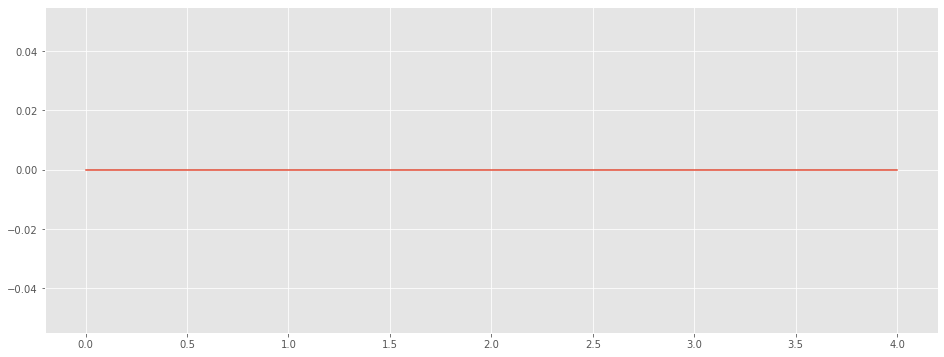

In [13]:
ppp.sum(axis=1).plot()

In [15]:
ppp

,a,b,c,d,e
0,-1.0,-1.0,NaN,1.0,1.0
1,-1.0,NaN,1.0,1.0,-1.0
2,-1.0,-1.0,NaN,1.0,1.0
3,-1.0,NaN,1.0,1.0,-1.0
4,-1.0,NaN,1.0,1.0,-1.0


In [18]:
df.values.sort()

In [20]:
df.to_numpy()

AttributeError: 'DataFrame' object has no attribute 'to_numpy'

In [21]:
df.values

array([[-1,  1,  1,  2,  6],
       [-1,  8, 10, 10, 11],
       [ 6,  8,  8,  9,  9],
       [ 8,  9, 11, 11, 12],
       [-3, -3, -1, -1,  0]], dtype=int64)

In [26]:
bb = np.array([df.columns] * df.shape[0])

In [27]:
bb

array([['a', 'b', 'c', 'd', 'e'],
       ['a', 'b', 'c', 'd', 'e'],
       ['a', 'b', 'c', 'd', 'e'],
       ['a', 'b', 'c', 'd', 'e'],
       ['a', 'b', 'c', 'd', 'e']], dtype=object)

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
pd.Series(np.arange(100)).rolling(90).mean()

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
      ... 
70     NaN
71     NaN
72     NaN
73     NaN
74     NaN
75     NaN
76     NaN
77     NaN
78     NaN
79     NaN
80     NaN
81     NaN
82     NaN
83     NaN
84     NaN
85     NaN
86     NaN
87     NaN
88     NaN
89    44.5
90    45.5
91    46.5
92    47.5
93    48.5
94    49.5
95    50.5
96    51.5
97    52.5
98    53.5
99    54.5
Length: 100, dtype: float64

In [1]:
df

NameError: name 'df' is not defined

In [24]:
df.plot()